### Libraries and packages

In [1]:
import numpy as np
import pandas as pd
import string
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

### Import of datas

In [2]:
data = pd.read_csv("/Users/FelicieBizeul/Desktop/ETUDES/ENSAI/Erasmus/SL/project/Try_bow/climate_change_tweets_sample_to_work_on.csv")
data.head()

,Unnamed: 0,username,user_handle,date,retweets,favorites,text,label
0,0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,In this difficult time it’s hard to connect w...,0
2,2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,The decision to postpone COP is unavoidab...,0
3,3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan the world’s fifth largest emitter of g...,0
4,4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include NatureBasedSolutio...,0


Here we use the file which already have been pre-processed, so our datas are cleans of '#' '@' etc

### Define the train and test samples of X and Y

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(data, data.label, test_size=0.33, random_state=42)

print("X_train.shape is : ", X_train.shape)
print("X_test.shape is : ", X_test.shape)
print("Y_train.shape is : ", Y_train.shape)
print("Y_test.shape is : ", Y_test.shape)

X_train.shape is :  (12066, 8)
X_test.shape is :  (5943, 8)
Y_train.shape is :  (12066,)
Y_test.shape is :  (5943,)


### Instantiation of our bags of words

In [4]:
# Declaration of the object with some conditions
vectorizer = CountVectorizer(stop_words = 'english', binary=True, min_df = 10)

# For create the document term matrix
X_train = vectorizer.fit_transform(X_train["text"])
X_test = vectorizer.transform(X_test["text"])

## LOGIT

### Logit without penalties    

In [5]:
logreg_without_penalties = LogisticRegression(penalty='none')

fitlog = logreg_without_penalties.fit(X_train, Y_train)
coef_log = fitlog.coef_
score_train = logreg_without_penalties.score(X_train,Y_train)
score_test = logreg_without_penalties.score(X_test,Y_test)

print("Coef training: {}".format(logreg_without_penalties.coef_))
print("Training set score : {:.3f}".format(score_train))
print("Test set score : {:.3f}".format(score_test))

Coef training: [[ 352.21624073  398.04499713 -206.42018779 ... -331.10995521
    56.2247488  1205.85083984]]
Training set score : 1.000
Test set score : 0.907


In [6]:
# X predict on our sample test
pred_logreg = logreg_without_penalties.predict(X_test)

confusion = confusion_matrix(Y_test, pred_logreg)
print("Matrice de confusion : {}".format(confusion))

Matrice de confusion : [[2154  261]
 [ 290 3238]]


### Lasso Penalty : With a l1 penalty for the general model

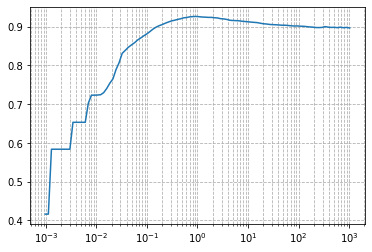

the best lambda is :  0.9324 with an acc of :  0.9262398064062687


In [7]:
# Here we find the best lamda
score_best = 0
acc_l=[]
lambda_best = 0
log = np.logspace(start = -10,stop = 10, num = 100, base = 2)

for i in log : 
    lasso_model_i = LogisticRegression(C=i,penalty='l1', solver='liblinear')
    lasso_fit = lasso_model_i.fit(X_train,Y_train)
    y_pred_val_i = lasso_model_i.predict(X_train)
    score_i = cross_val_score(lasso_model_i, X_train, Y_train, cv=5, scoring='accuracy')
    acc_i = np.mean(score_i)
    acc_l.append(acc_i)
    
    if acc_i > score_best :
        score_best = acc_i
        lambda_best = i
        
plt.plot(log,acc_l)
plt.xscale('log')
plt.grid(True, which ="both",linestyle ='--')
plt.show()

print("the best lambda is : ", round(lambda_best,4), "with an acc of : ",score_best)

In [8]:
# Here is the best model with the best penalty for Lasso :
best_model_lasso = LogisticRegression(C=lambda_best, penalty='l1',solver='liblinear')
best_model_lasso.fit(X_train, Y_train)

LogisticRegression(C=0.9323799583681278, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
coef_log_best_model_lasso = best_model_lasso.coef_
score_train_best_model_lasso = best_model_lasso.score(X_train,Y_train)
score_test_best_model_lasso = best_model_lasso.score(X_test,Y_test)

print("Coef training: {}".format(best_model_lasso.coef_))
print("Training set score : {:.3f}".format(score_train_best_model_lasso))
print("Test set score : {:.3f}".format(score_test_best_model_lasso))

Coef training: [[ 0.          0.          0.         ... -0.47377146  0.
   2.73131574]]
Training set score : 0.965
Test set score : 0.926


In [10]:
# X predict on our test sample
pred_best_model_lasso = best_model_lasso.predict(X_test)

confusion_best_model_lasso = confusion_matrix(Y_test, pred_best_model_lasso)
print("Matrice de confusion : {}".format(confusion_best_model_lasso))

Matrice de confusion : [[2227  188]
 [ 251 3277]]


### ROC curve for our two models to compare them

In [12]:
logit_roc_auc_best_model_lasso = roc_auc_score(Y_test, best_model_lasso.predict(X_test))
logit_roc_auc_without_penalty = roc_auc_score(Y_test, logreg_without_penalties.predict(X_test))

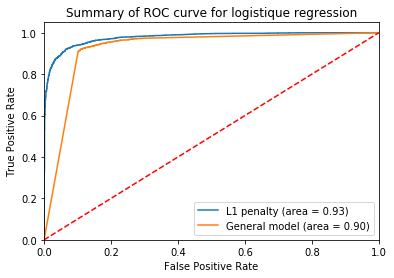

In [14]:
fpr_b, tpr_b, thresholds_b = roc_curve(Y_test, best_model_lasso.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, logreg_without_penalties.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr_b, tpr_b, label='L1 penalty (area = %0.2f)' % logit_roc_auc_best_model_lasso)
plt.plot(fpr, tpr, label='General model (area = %0.2f)' % logit_roc_auc_without_penalty)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Summary of ROC curve for logistique regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Here, the L1 penalty model is the best one without cross validation with our split of datas.
We can perform a 5 cross validation on our two models. 

### 5 cross validation on our models

In [15]:
#### Model logistic without penalty

In [16]:
scores_logreg_without_penalties = cross_val_score(LogisticRegression(penalty = 'none'), X_train, Y_train, cv = 5)
print("CV accuracy : {}".format(scores_logreg_without_penalties)) #Afficher la moyenne des scores
print("Mean CV accuracy : {:.2f}".format(np.mean(scores_logreg_without_penalties))) #Afficher la moyenne des scores

/Users/FelicieBizeul/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CV accuracy : [0.9067937  0.90385412 0.90509739 0.91504351 0.90965603]
Mean CV accuracy : 0.91


In [17]:
#### Model logistic with lasso penalty

In [18]:
scores_best_model_lasso  = cross_val_score(LogisticRegression(C=lambda_best, penalty='l1',solver='liblinear'), X_train, Y_train, cv = 5)
print("CV accuracy : {}".format(scores_best_model_lasso)) #Afficher la moyenne des scores
print("Mean CV accuracy : {:.2f}".format(np.mean(scores_best_model_lasso))) #Afficher la moyenne des scores

CV accuracy : [0.91673571 0.92457522 0.9241608  0.93493576 0.93120597]
Mean CV accuracy : 0.93


The best model is the one with the lasso penalty even if with cross validation. 